In [1]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.signal import savgol_filter
import math
import boris_extraction as boris
import pandas as pd
from scipy.stats import sem
from statistics import mean
from scipy.stats import wilcoxon

In [2]:
def get_spiketrain(timestamp_array, timebin =1, sampling_rate=20000):
    """
    creates a spiketrain of ms time bins 
    each array element is the number of spikes recorded per ms
    
    Args (3 total):
        timestamp_array: numpy array, spike timestamp array
        timebin: int, default=1, timebin (ms) of resulting spiketrain
        sampling_rate: int, default=20000, sampling rate in Hz of the ephys recording
        
    Returns (1):
        spiketrain: numpy array, array elements are number of spikes per timebin
    """
    
    hz_to_timebin = int(sampling_rate*.001*timebin)
    spiketrain = np.histogram(timestamp_array, bins=np.arange(0, timestamp_array[-1], hz_to_timebin))[0]
    
    return spiketrain


def get_firing_rate(spiketrain, smoothing_window = 250, timebin=1):
    """
    calculates firing rate (spikes/second)
    
    Args (3 total, 1 required):
        spiketrain: numpy array, in timebin (ms) bins
        smoothing_window: int, default=250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, timebin (ms) of spiketrain

    Return (1):
        firing_rate: numpy array of firing rates in timebin sized windows
        
    """ 
    weights = np.ones(smoothing_window) / smoothing_window * 1000 / timebin 
    firing_rate = np.convolve(spiketrain, weights, mode='same')

    return firing_rate


def get_event_lengths(events):
    """
    calculates event lengths and longest event length

    Args (1):
        events:numpy array of [[start (ms), stop (ms)] x n events]

    Returns (2):
        max event length: int, longest event length in ms
        event_lengths: lst of ints, event lengths in ms
    """
    event_lengths = []
    for i in range(events.shape[0]):
        event_length = int(events[i][1] - events[i][0])
        event_lengths.append(event_length)
    return max(event_lengths), event_lengths


def trim_event(event, max_event):
    """
    trims events to a given length
    Args (2 total):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        max_event: int, max length (s) of event desired

    Returns (1):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        with none longer than max_event
    """
    if event[1] - event[0] > (max_event*1000):
        event[1] = event[0]+(max_event*1000)
        event[0] = event[0]  
    return np.array(event)


def pre_event_window(event, baseline_window):
    """
    creates an event like object np.array[start(ms), stop(ms)] for
    baseline_window amount of time prior to an event

    Args (2 total):
        event: np.array[start(ms), stop(ms)]
        baseline_window: int, seconds prior to an event

    Returns (1):
        preevent: np.array, [start(ms),stop(ms)] baseline_window (s) before event
    """
    preevent = [event[0] - (baseline_window*1000)-1, event[0]-1]
    return np.array(preevent)


def max_events(unit_dict, max_event, pre_window, timebin = 1):
    """
    creates a dictionary with unit firing rates during events no longer
    than max_event (s) (all longer events will be trimmed) and start times
    adjusted to include pre_window time (s)

    Args (4 total):
        unit_dict: dict, unit id as keys, and values are spiketrains or firing rates 
        max_event: int, longest event length (s) returned (all longer events will be trimmed)
        pre_window: int, amount of preevent time (s) returned
        timebin: timebin (ms) of dict

    Returns (1):
        snippets_dict: dict, unit id as keys, values are spiketrains or firing rates during
        pre_window and up until max event 
    """
    
    snippets_dict = {}
    for unit in unit_dict.keys():
        events = unit_dict[unit]
        try:
            events = [event[0:int((pre_window + max_event)*1000/timebin)] for event in events]
        except IndexError:
            pass
        snippets_dict[unit] = events
    return snippets_dict


class EphysRecording:
    """
    A class for an ephys recording after being spike sorted and manually curated using phy. 
    Ephys recording must have a phy folder. 

    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        timestamps_var: numpy array, all spike timestamps 
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes 
            from "good" units only 

    Methods: (all called in __init__)
        get_unit_labels: creates labels_dict
        get_spike_specs: creates timestamps_var and unit_array
        get_unit_timestamps: creates unit_timestamps dictionary
    """
    
    def __init__(self, path, sampling_rate=20000):
        """
        constructs all necessary attributes for the EphysRecording object
        including creating labels_dict, timestamps_var, and a unit_timstamps 
        dictionary 
        
        Arguments (2 total):
            path: str, relative path to the phy folder
                formatted as: './folder/folder/phy'
            sampling_rate: int, default=20000; sampling rate of 
                the ephys device in Hz
        Returns:
            None
        """
        self.path = path
        self.sampling_rate = sampling_rate
        self.get_unit_labels()
        self.get_spike_specs()
        self.get_unit_timestamps()

    
    def get_unit_labels(self):
        """
        assigns self.labels_dicts as a dictionary 
        with unit id (str) as key and label as values (str)
        labels: 'good', 'mua', 'noise' 

        Arguments:
            None

        Returns:
            None
        """
        labels = 'cluster_group.tsv'
        with open(os.path.join(self.path, labels), 'r') as f:
            reader = csv.DictReader(f, delimiter='\t')
            self.labels_dict = {row['cluster_id']: row['group'] for row in reader}

    
    def get_spike_specs(self):
        """
        imports spike_time and spike_unit from phy folder
        deletes spikes from units labeled noise in unit and timestamp array
        and assigns self.timstamps_var (numpy array) as the remaining timestamps 
        and assigns self.unit_array (numpy array) as the unit ids associated
        with each spike
        
        Args:
            None
        
        Returns:
            None 
        """
        timestamps = 'spike_times.npy'
        unit = 'spike_clusters.npy'
        timestamps_var = np.load(os.path.join(self.path, timestamps))
        unit_array = np.load(os.path.join(self.path, unit))
        spikes_to_delete = []
        for spike in range(len(timestamps_var)): 
            if self.labels_dict[unit_array[spike].astype(str)] == 'noise':
                spikes_to_delete.append(spike)
        self.timestamps_var = np.delete(timestamps_var, spikes_to_delete)
        self.unit_array = np.delete(unit_array, spikes_to_delete)

    
    def get_unit_timestamps(self):
        """
        creates a dictionary of units to spike timestamps
        keys are unit ids (int) and values are spike timestamps for that unit (numpy arrays)
        and assigns dictionary to self.unit_timestamps
        
        Args:
            None
        
        Return:
            None
        """
        
        unit_timestamps = {}
        for spike in range(len(self.timestamps_var)): 
            if self.unit_array[spike] in unit_timestamps.keys():
                timestamp_list = unit_timestamps[self.unit_array[spike]] 
                timestamp_list = np.append(timestamp_list, self.timestamps_var[spike])
                unit_timestamps[self.unit_array[spike]] = timestamp_list
            else:
                unit_timestamps[self.unit_array[spike]] = self.timestamps_var[spike]
        
        self.unit_timestamps = unit_timestamps   


class EventTriggeredAverages:
    """
    A class for an event triggered average object that needs
    an EphysRecording class instance 
    and an event array [[start (ms), stop(ms)]..]
    

    Attributes:
        event: str, name of the event 
        events: numpy array of [[start (ms), stop (ms)] x n events]
        smoothing_window: int, default=250, window length in ms used to calculate firing rates
        timebin: int, default=1, bin size (in ms) for spike train and firing rate arrays
        ingore_freq: int, default=0, frequency in Hz that a good unit needs to fire at to be included in analysis
        longest_event: int, length of longest event (ms)
        event_lengths: lst, length of all events (ms)
        spiketrain: numpy array, each element of the array 
            is the number of spikes per timebin throughout the whole recording
        unit_spiketrains: dict, keys are unit ids (int), values (numpy arrays) are each "good"
            units spiketrains in the specified timebins for the whole recording
        unit_firing_rates: dict, keys are unit ids (int), values (numpy array) are each "good"
            units firing rates calculated using smoothing_window in bins of size timebin

    Methods: 
        get_whole_spiketrain: 
        get_unit_spiketrains: 
        get_unit_firing_rates: 
        get_event_snippets:
        get_unit_event_firing_rates:
        wilcox_baseline_v_event_stats:
        wilcox_baseline_v_event_plots:
    """
    def __init__(self, event, events, recording, smoothing_window=250, timebin=1, ignore_freq=0):
        
        self.recording = recording
        self.event = event
        self.events = events
        self.smoothing_window = smoothing_window
        self.timebin = timebin
        self.ignore_freq = ignore_freq
        self.longest_event, self.event_lengths = get_event_lengths(events)
        self.get_whole_spiketrain()
        self.get_unit_spiketrains()
        self.get_unit_firing_rates()

    
    def get_whole_spiketrain(self):
        """
        creates a spiketrain of ms time bins 
        each array element is the number of spikes recorded per ms
        
        Args (1 total):
            timestamp_array: numpy array, spike timestamp array
            
        Returns (1):
            spiketrain_ms_timebins: a numpy array 
                array elements are number of spikes per ms 
        """
        self.spiketrain = get_spiketrain(self.recording.timestamps_var, self.recording.sampling_rate, self.timebin)

    
    def get_unit_spiketrains(self):  
        """
        Creates a dictionary and assigns it as self.unit_spiketrains
        where keys are 'good' unit ids (int) (not 'mua') that reach
        a threhold frequency, values are numpy arrays of 
        spiketrains in timebin sized bins
        
        Args:
            None
            
        Reutrns:
            None
            
        """
        unit_spiketrains = {}
        for unit in self.recording.unit_timestamps.keys():
            if self.recording.labels_dict[str(unit)] == 'good':
                no_spikes = len(self.recording.unit_timestamps[unit])
                unit_freq = no_spikes/self.recording.timestamps_var[-1]*self.recording.sampling_rate
                if unit_freq > self.ignore_freq:
                    unit_spiketrains[unit] = get_spiketrain(self.recording.unit_timestamps[unit], 
                                                            self.recording.sampling_rate, self.timebin)
        self.unit_spiketrains = unit_spiketrains    

    
    def get_unit_firing_rates(self):  
        """
        Calculates firing rates per unit,
        creates a dictionary and assigns it as self.unit_firing_rates
        the keys are unit ids (int) and values are firing rates for the
        unit (numpy array) in timebin sized bins 
        calculated using smoothing_window for averaging
        
        Args:
            none
            
        Returns:
            none
        """
        unit_firing_rates = {}
        for unit in self.unit_spiketrains.keys():
            unit_firing_rates[unit] = get_firing_rate(self.unit_spiketrains[unit], self.smoothing_window, self.timebin)
        self.unit_firing_rates = unit_firing_rates

    
    def get_event_snippets(self, whole_recording, pre_window=0, post_window=0, equalize = False, events = None):
        """
        takes snippets of spiketrains or firing rates for events
        optional pre-event and post-event windows (s) may be included
        all events can also be of equal length by extending 
        snippet lengths to the longest event
    
        Args (5 total, 1 required): 
            whole_recording: numpy array, spiketrain or firing rates 
                for the whole recording, for population or for a single unit
            pre_window: int, default=0, seconds prior to start of event returned
            post_window: int, default=0, seconds after end of event returned
            equalize: Boolean, default=False, if True, equalizes lengths of each event to longest event
            events:numpy array of [[start (ms), stop (ms)] x n events], 
                default=None in which case self.events is used
    
        Returns (1):
            event_snippets: a list of lists, where each list is a list of firing rates
                or spiketrains during an event including pre_window&post_windows, 
                accounting for equalize and timebins
        """
        
        if events is None:
            events = self.events
        event_snippets = []
        pre_window = math.ceil(pre_window*1000)
        post_window = math.ceil(post_window*1000)
        for i in range(events.shape[0]):
            if equalize:
                event_diff = int((self.longest_event - self.event_lengths[i]))
            else:
                event_diff = 0
            pre_event = int((events[i][0] - pre_window)/self.timebin)
            post_event = int((events[i][1] + post_window + event_diff)/self.timebin)
            event_snippet = whole_recording[pre_event:post_event]
            event_snippets.append(event_snippet)
        return event_snippets

    
    def get_unit_event_firing_rates(self, pre_window = 0, post_window = 0, equalize = False, events = None):
        """
        returns firing rates for events per unit
    
        Args (6 total, 1 required):
            smoothing_window: int, default=250, smoothing average window (ms)
                min smoothing_window = 1 
            timebin: int, default 1, timebin in ms for firing rate array
            pre_window: int, default=0, seconds prior to start of event returned
            post_window: int, default=0, seconds after end of event returned
            equalize: Boolean, default=False, if True, equalizes lengths of each event to longest event
            events:numpy array of [[start (ms), stop (ms)] x n events], 
                default=None in which case self.events is used
            
        Return (1):
            unit_event_firing_rates: dict, keys are unit ids (???),
            values are lsts of numpy arrays of firing rates per event
        """
        unit_event_firing_rates = {}
        for unit in self.unit_spiketrains.keys():
            unit_event_firing_rates[unit] = self.get_event_snippets(self.unit_firing_rates[unit], pre_window, post_window, equalize, events)
        return unit_event_firing_rates


    def wilcox_baseline_v_event_stats(self, baseline_window, max_event=None, equalize = False):
        #what if i wanted a random snippet from the first ten minutes instead of prior to the event?
        """
        calculates wilcoxon signed-rank test for average firing rates of two windows: event vs baseline
        baseline used is an amount of time immediately prior to the event
        wilcoxon signed-rank test is applied to two sets of measurements:
        average firing rate per event, average firing rate per baseline
        
        Args (3 total, 1 required):
            baseline_window: int, length of baseline firing rate (s)
            max_event: int, default=None, max length of an event (s)
            equalize: Boolean, default=False, if True, equalizes lengths of each event to longest event
    
        Return (1):
            wilcoxon_df: pandas dataframe, columns are unit ids, 
            row[0] are wilcoxon statistics and row[1] are p values 
        
        """
        preevent_baselines = np.array([pre_event_window(event, baseline_window) for event in self.events])
        unit_preevent_firing_rates = self.get_unit_event_firing_rates(0,0,False,preevent_baselines)
        unit_event_firing_rates = self.get_unit_event_firing_rates(0,0,equalize)
        if max_event is not None:
            unit_event_firing_rates = max_events(unit_event_firing_rates, max_event, 0, self.timebin)
        unit_averages = {}
        for unit in unit_event_firing_rates:
            try:
                event_averages = [mean(event) for event in unit_event_firing_rates[unit]]
                preevent_averages = [mean(event) for event in unit_preevent_firing_rates[unit]]
                unit_averages[unit] = [event_averages, preevent_averages]
            except:
                print(f'Unit {unit} has {len(self.recording.unit_timestamps[unit])} spikes')
        wilcoxon_stats = {}
        for unit in unit_averages.keys(): 
            wilcoxon_stats[unit] = wilcoxon(unit_averages[unit][0], unit_averages[unit][1], method = 'approx')
        wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats)
        self.baseline_window = baseline_window
        self.max_event = max_event
        self.wilcoxon_df = wilcoxon_df
        
    def wilcox_baseline_v_event_plots(self, title, p_value=None, units=None):
        """
        plots event triggered average firing rates for units
        all events need to be the same length

        Args(3 total, 1 required):
            title: str, title of figure
            p_value: int, default=None, all p values less than will be plotted
            units: lst, default=None, list of unit ids (ints) to be plotted

        Returns:
            none
        """ 
        units_to_plot = []
        if p_value is not None:
            for unit in self.wilcoxon_df.columns.tolist():
                if self.wilcoxon_df[unit][1] < p_value:
                      units_to_plot.append(unit)
        else:
            if units is None:
                units_to_plot = self.wilcoxon_df.columns.tolist()
            else:
                units_to_plot = units
        no_plots = len(units_to_plot)
        height_fig = math.ceil(no_plots/3)
        i = 1
        plt.figure(figsize=(20,4*height_fig))
        unit_event_firing_rates = self.get_unit_event_firing_rates(self.baseline_window, 0, True)
        if self.max_event is not None:
            unit_event_firing_rates = max_events(unit_event_firing_rates, self.max_event, self.baseline_window)
        for unit in units_to_plot:
            mean_arr = np.mean(unit_event_firing_rates[unit], axis=0)
            sem_arr = sem(unit_event_firing_rates[unit], axis=0)
            p_value = self.wilcoxon_df[unit][1]
            x = np.linspace(start=-self.baseline_window,stop=self.max_event,num=len(mean_arr))
            plt.subplot(height_fig,3,i)
            plt.plot(x, mean_arr, c= 'b')
            plt.axvline(x=0, color='r', linestyle='--')
            plt.fill_between(x, mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
            plt.title(f'Unit {unit} Average (p={p_value})')
            i+=1
        plt.suptitle(title)
        plt.show()

    def wilcoxon_average_firingrates(self, event1, event2, max_event=None, equalize = False):
        #what if i wanted a random snippet from the first ten minutes instead of prior to the event?
        """
        calculates wilcoxon signed-rank test for average firing rates of two windows: event vs baseline
        baseline used is an amount of time immediately prior to the event
        wilcoxon signed-rank test is applied to two sets of measurements:
        average firing rate per event, average firing rate per baseline
        
        Args (3 total, 1 required):
            baseline_window: int, length of baseline firing rate (s)
            max_event: int, default=None, max length of an event (s)
            equalize: Boolean, default=False, if True, equalizes lengths of each event to longest event
    
        Return (1):
            wilcoxon_df: pandas dataframe, columns are unit ids, 
            row[0] are wilcoxon statistics and row[1] are p values 
        
        """
        unit_event1_firing_rates = self.get_unit_event_firing_rates(0,0,equalize, event1)
        unit_event2_firing_rates = self.get_unit_event_firing_rates(0,0,equalize, event2)
        if max_event is not None:
            unit_event1_firing_rates = max_events(unit_event1_firing_rates, max_event, 0, self.timebin)
            unit_event2_firing_rates = max_events(unit_event2_firing_rates, max_event, 0, self.timebin)
        unit_averages = {}
        for unit in unit_event_firing_rates:
            try:
                event1_averages = [mean(event) for event in unit_event1_firing_rates[unit]]
                event2_averages = [mean(event) for event in unit_event2_firing_rates[unit]]
                unit_averages[unit] = [event1_averages, event2_averages]
            except:
                print(f'Unit {unit} has {len(self.recording.unit_timestamps[unit])} spikes')
        wilcoxon_stats = {}
        for unit in unit_averages.keys(): 
            wilcoxon_stats[unit] = wilcoxon(unit_averages[unit][0], unit_averages[unit][1], method = 'approx')
        wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats)
        self.max_event = max_event
        self.wilcoxon_df = wilcoxon_df

    def get_zscore(self, baseline_window):
        #nancy had a matrix of (neuron, timebin, trial) 
        preevent_baselines = np.array([pre_event_window(event, baseline_window) for event in self.events])
        unit_event_firing_rates = self.get_unit_event_firing_rates(pre_window=baseline_window, post_window=0, equalize=True)
        unit_preevent_firing_rates = self.get_unit_event_firing_rates(0,0,False,preevent_baselines)
        zscored_events = {}
        for unit in unit_event_firing_rates:
            #calculate average event across all events per unit
            event_average = np.mean(unit_event_firing_rates[unit], axis = 0)
            #one average for all preevents 
            preevent_average = np.mean(unit_preevent_firing_rates[unit], axis = 0)
            mew = np.mean(preevent_average)
            sigma = np.std(preevent_average)
            zscored_event = [(event_bin - mew)/sigma for event_bin in event_average]
            zscored_events[unit] = zscored_event
        self.zscored_events = zscored_events
        
    def get_zcore_plot(self, baseline_window, max_event, title):
        plt.figure(figsize=(20,6))
        zscored_unit_event_firing_rates = self.zscored_events
        if max_event is not None:
            zcored_unit_event_firing_rates = max_events(zscored_unit_event_firing_rates, max_event, baseline_window)
        zscore_pop = np.array(list(zscored_unit_event_firing_rates.values()))
        print(zscore_pop.shape)
        mean_arr = np.mean(zscore_pop, axis=0)
        
        sem_arr = sem(zscore_pop, axis=0)
        x = np.linspace(start=-baseline_window,stop=max_event,num=len(mean_arr))
        plt.subplot(1,2,1)
        plt.plot(x, mean_arr, c= 'b')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.fill_between(x, mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
        plt.title(f'Population z-score {self.event} event')
        plt.subplot(1,2,2)
        for unit in zscored_unit_event_firing_rates.keys():
            plt.plot(x, zscored_unit_event_firing_rates[unit], linewidth = .5)
            plt.axvline(x=0, color='r', linestyle='--')
            plt.title(f'Unit z-score {self.event} event')
        plt.suptitle(f'{title} Z-scored average {self.event} event')
        plt.show()        
                

In [3]:
fam = EphysRecording(path=".\\proc\\20221219_114535_6_1_fam_merged.rec\\phy", sampling_rate = 20000)


In [4]:
boris_df = pd.read_excel('C:\\Users\megha\\Documents\\Padilla-Coreano\\homecage_social_ephys_vids\\mp4vids\\annotated_behavior_cagfamnov.xlsx')
fam_df = boris_df[boris_df['Observation id'] == 'familiar_6_1_06282023']
sniffing_bouts = boris.get_behavior_bouts(fam_df, ['subject'], ['anogential sniffing', 'face sniffing'], 2, .3)
fam_sniff = EventTriggeredAverages('sniffing', sniffing_bouts, fam, 250)
fam_sniff.get_unit_event_firing_rates(2,0,True)
fam_sniff.get_zscore(2)
len(fam_sniff.zscored_events[1])


19066

(5, 19066)


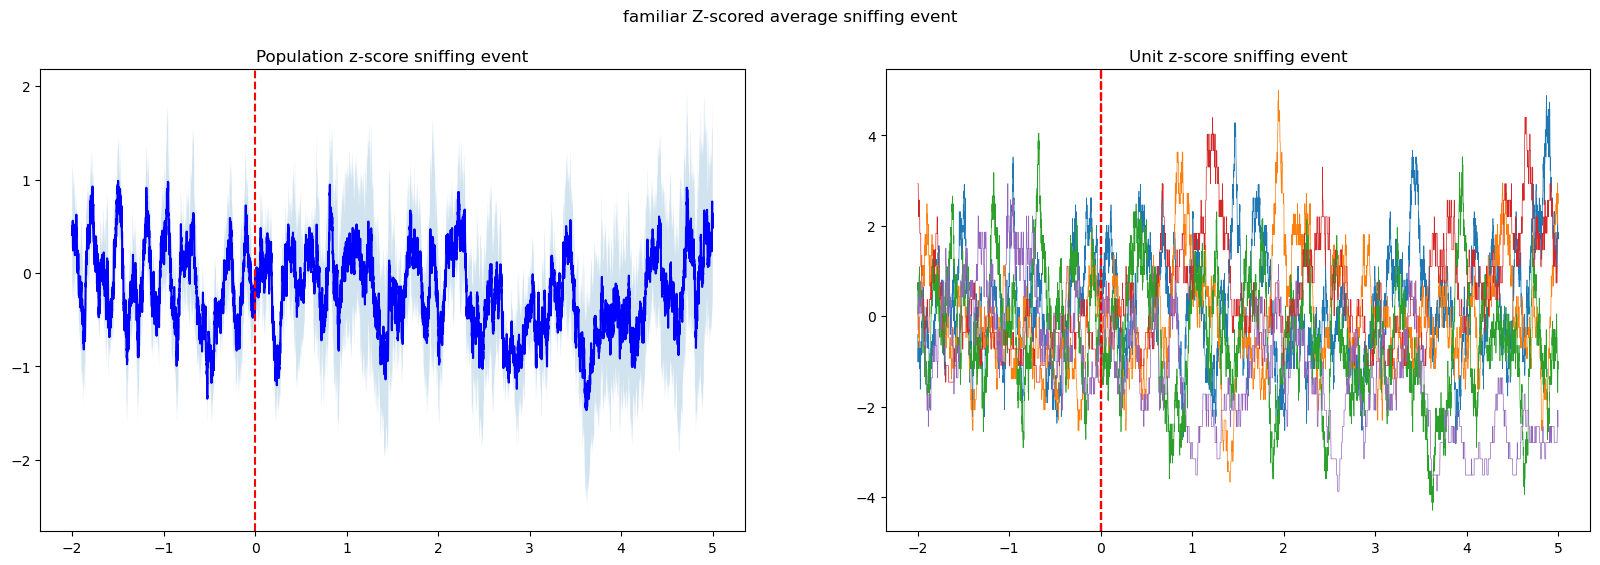

In [5]:
fam_sniff.get_zcore_plot(2,5, 'familiar')

In [6]:
fam_sniff.wilcoxon_average_firingrates(2,5)
fam_sniff.wilcoxon_df

AttributeError: 'int' object has no attribute 'shape'

In [ ]:
fam_sniff.wilcoxon_df

In [7]:
novel = EphysRecording(path=".\\proc\\20221219_124942_6_1_novel_merged.rec\\phy", sampling_rate = 20000)
novel_df = boris_df[boris_df['Observation id'] == 'novel_6_1_06282023']
novel_sniffing_bouts = boris.get_behavior_bouts(novel_df, ['subject'], ['anogential sniffing', 'face sniffing'], 2, .3)
novel_sniff = EventTriggeredAverages('sniffing', novel_sniffing_bouts, novel, 100, 1,.1)
novel_sniff.get_zscore(2)

(14, 8567)


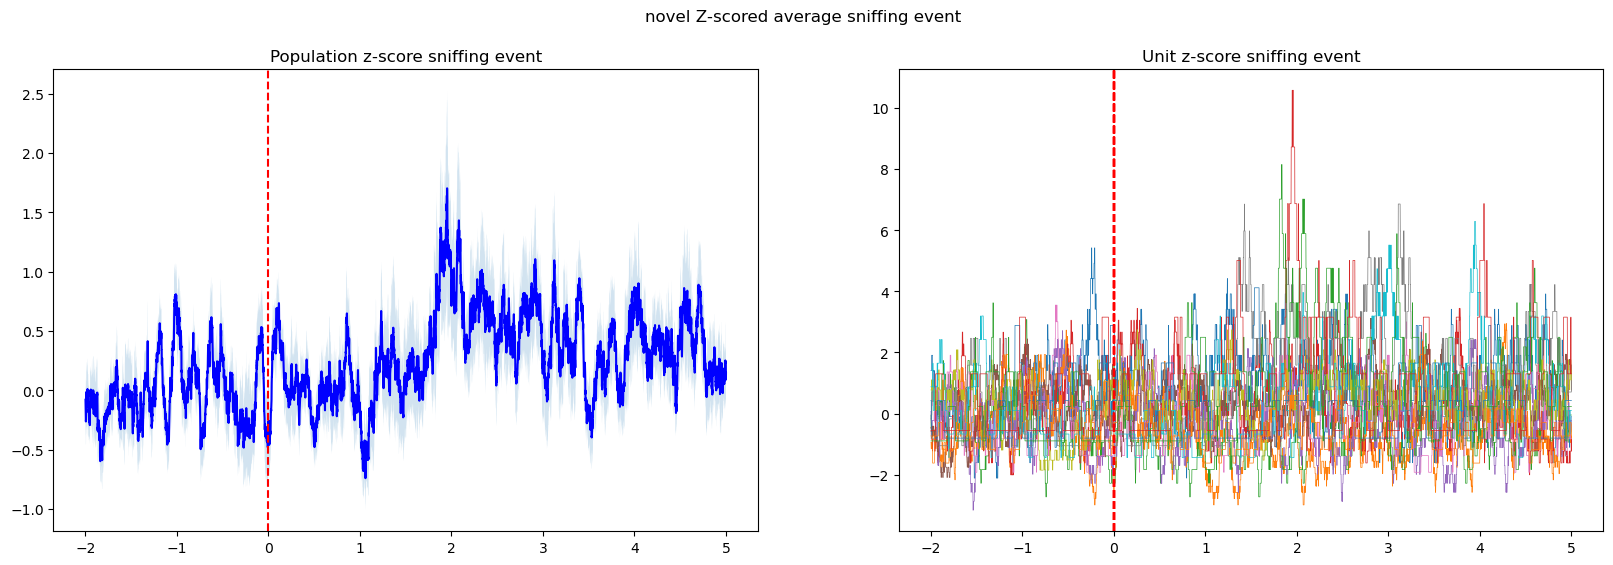

In [8]:
novel_sniff.get_zcore_plot(2,5, 'novel',)

In [ ]:
novel_sniff.wilcoxon_average_firingrates(2,5)
novel_sniff.wilcoxon_df

In [ ]:
novel_sniff.eda_wilcoxon_event_plots('2v5', units = [98, 115])

In [ ]:
novel_sniff.wilcoxon_average_firingrates(5,5)
novel_sniff.wilcoxon_df


In [ ]:
novel_sniff.eda_wilcoxon_event_plots('5v5', p_value = .1)

In [ ]:
novel = EphysRecording(path=".\\proc\\20221219_124942_6_1_novel_merged.rec\\phy", sampling_rate = 20000)
novel_df = boris_df[boris_df['Observation id'] == 'novel_6_1_06282023']
novel_sniffing_bouts = boris.get_behavior_bouts(novel_df, ['novel'], ['anogential sniffing', 'face sniffing'], 2, .3)
novel_sniff = EventTriggeredAverages('sniffing', novel_sniffing_bouts, novel, 100)
unit_event_firing_rates = novel_sniff.get_unit_event_firing_rates(2,0,True)
novel_sniff.wilcoxon_average_firingrates(5,5)
novel_sniff.wilcoxon_df

In [ ]:
novel_sniff.eda_wilcoxon_event_plots(title = '5v5 novel sniffing', p_value = .1)

In [9]:
cagemate = EphysRecording(path=".\\proc\\20221219_141311_6_1_cagemate_merged.rec\\phy", sampling_rate = 20000)
cagemate_df = boris_df[boris_df['Observation id'] == 'cagemate_6_1_06282023']
cagemate_sniffing_bouts = boris.get_behavior_bouts(cagemate_df, ['subject'], ['anogential sniffing', 'face sniffing'], 2, .3)
cagemate_sniff = EventTriggeredAverages('sniffing', cagemate_sniffing_bouts, cagemate, 250)


In [ ]:
cagemate_sniff.eda_wilcoxon_event_plots(title = '2v5 cagemate', p_value = .15)

In [ ]:
cagemate_sniff.wilcoxon_average_firingrates(5,5)
cagemate_sniff.wilcoxon_df

In [ ]:
#novel_sniff.eda_wilcoxon_event_plots(title = 'novel', p_value = .75)
cagemate_sniff.eda_wilcoxon_event_plots(title = '5v5 cagemate', p_value = .15)
#fam_sniff.eda_wilcoxon_event_plots(title = 'familiar', p_value = .75)

In [ ]:
cagemate = EphysRecording(path=".\\proc\\20221219_141311_6_1_cagemate_merged.rec\\phy", sampling_rate = 20000)
cagemate_df = boris_df[boris_df['Observation id'] == 'cagemate_6_1_06282023']
cagemate_sniffing_bouts = boris.get_behavior_bouts(cagemate_df, ['cagemate'], ['anogential sniffing', 'face sniffing'], 2, .3)
cagemate_sniff = EventTriggeredAverages('sniffing', cagemate_sniffing_bouts, cagemate, 250)


(15, 7767)


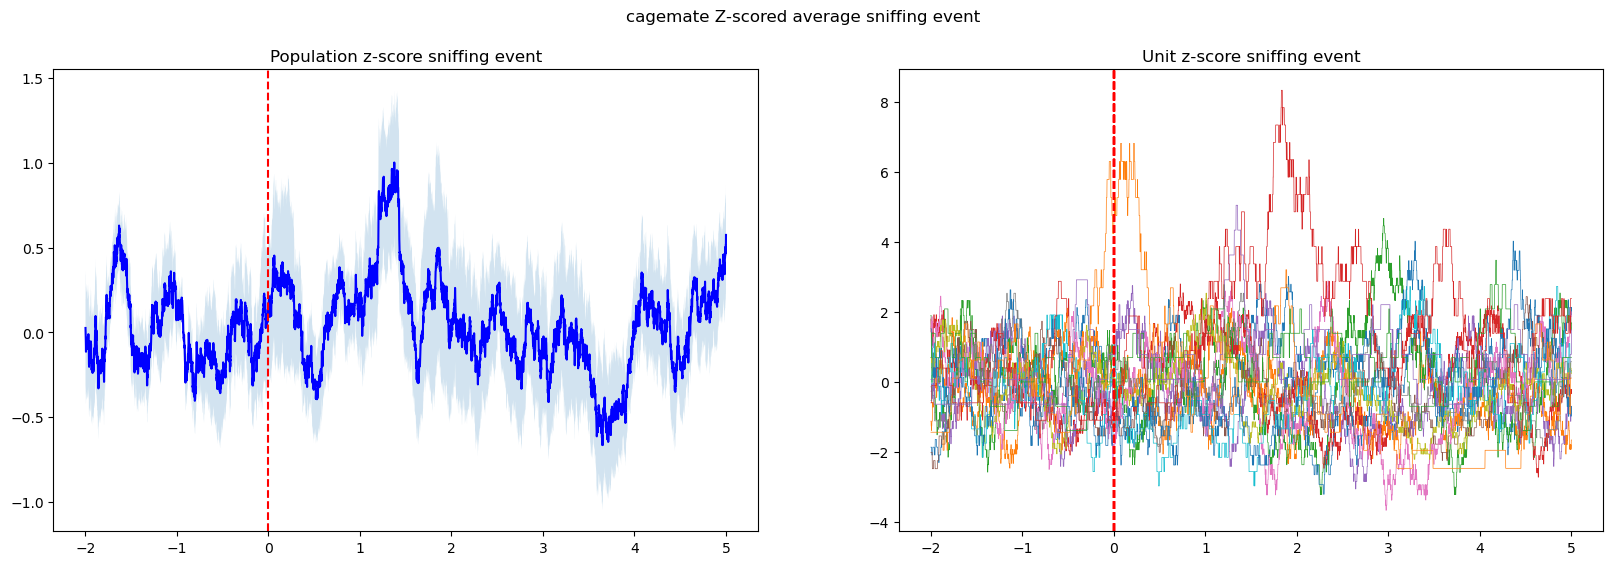

In [11]:
cagemate_sniff.get_zscore(2)
cagemate_sniff.get_zcore_plot(2,5, 'cagemate')

In [ ]:
cagemate_sniff.eda_wilcoxon_event_plots(title = 'cagemate sniffing', p_value = .15)

In [ ]:
int(2.5)

In [ ]:
int(2.9)

In [ ]:
len(self.recording.unit_timestamps[unit])/(self.recording.timestamps_var[-1]/self.sampling_rate)

In [ ]:
len(novel.unit_timestamps[160])/novel.timestamps_var[-1]*novel.sampling_rate

In [ ]:
mew = np.mean(np.mean([[1,2],[2,1],[3,5],[4,6]], axis = 0))
mew

In [ ]:
mew = np.mean(avg_event)

In [ ]:
mew

In [ ]:
temp_dict = {1:[1,2], 2:[1,3], 3:[5,6]}
arrays_temp = np.array(list(temp_dict.values()))
arrays_temp

In [ ]:
mean_dict_value = np.mean(arrays_temp,axis = 0)